In [3]:
import json
import numpy as np
import pandas as pd
from pathlib import Path

def read_json(p: Path) -> dict:
    return json.loads(p.read_text(encoding="utf-8"))

def extract_ept_total(obj: dict) -> float:
    for k in ["EPT_total_J_per_tok", "ept_total_J_per_tok", "EPT_total", "EPT_total_J"]:
        if k in obj and obj[k] is not None:
            return float(obj[k])
    raise KeyError(f"No EPT_total key found. Keys: {list(obj.keys())[:20]}")

def load_ept_single(root: Path, rel: str, fname="ept.json") -> float:
    p = root / rel / fname
    if not p.exists():
        raise FileNotFoundError(f"Missing: {p}")
    return extract_ept_total(read_json(p))

EPT_CFG = {
    "ROOT": Path("."),
    "EPT_NAME": "ept.json",

    "KD_GROUPS": {
        "FEATURE":  [f"FEATURE/MODEL {i}" for i in range(1, 6)],
        "RESPONSE": [f"RESPONSE/MODEL {i}" for i in range(1, 6)],
        "RELATION": [f"RELATION/MODEL {i}" for i in range(1, 6)],
    },

    "BASELINES": {
        "Teacher":      "BASE/TEACHER",
        "Student":      "BASE/STUDENT",
        "Traditional":  "TRADITIONAL STUDENT",
    },

    "ORDER": ["Teacher", "Student", "Traditional", "FEATURE", "RESPONSE", "RELATION"],

    # model sizes (B params)
    "PARAMS_B": {
        "Teacher": 70.0,
        "Student": 8.0,
        "Traditional": 8.0,
        "FEATURE": 8.0,
        "RESPONSE": 8.0,
        "RELATION": 8.0,
    },
}

def build_ept_points(cfg: dict) -> pd.DataFrame:
    root = cfg["ROOT"]
    fname = cfg["EPT_NAME"]
    params = cfg["PARAMS_B"]

    rows = []

    # baselines: single point each
    for method, folder in cfg["BASELINES"].items():
        ept = load_ept_single(root, folder, fname)
        rows.append({
            "method": method,
            "ept": ept,
            "params_b": params[method],
            "run": 1,
            "path": str((root / folder / fname))
        })

    # KD groups: 5 points each
    for method, paths in cfg["KD_GROUPS"].items():
        for i, rel in enumerate(paths, start=1):
            ept = load_ept_single(root, rel, fname)
            rows.append({
                "method": method,
                "ept": ept,
                "params_b": params[method],
                "run": i,
                "path": str((root / rel / fname))
            })

    df = pd.DataFrame(rows)
    df["method"] = pd.Categorical(df["method"], categories=cfg["ORDER"], ordered=True)
    df = df.sort_values(["method", "run"]).reset_index(drop=True)
    return df

df_ept_points = build_ept_points(EPT_CFG)
df_ept_points


,method,ept,params_b,run,path
0,Teacher,354.750412,70.0,1,BASE/TEACHER/ept.json
1,Student,0.332404,8.0,1,BASE/STUDENT/ept.json
2,Traditional,0.342757,8.0,1,TRADITIONAL STUDENT/ept.json
3,FEATURE,0.437942,8.0,1,FEATURE/MODEL 1/ept.json
4,FEATURE,0.441917,8.0,2,FEATURE/MODEL 2/ept.json
5,FEATURE,0.447308,8.0,3,FEATURE/MODEL 3/ept.json
6,FEATURE,0.448218,8.0,4,FEATURE/MODEL 4/ept.json
7,FEATURE,0.449822,8.0,5,FEATURE/MODEL 5/ept.json
8,RESPONSE,0.478475,8.0,1,RESPONSE/MODEL 1/ept.json
9,RESPONSE,0.486467,8.0,2,RESPONSE/MODEL 2/ept.json


In [4]:
df_means = df_ept_points.groupby('method').agg({
    'ept': ['mean', 'std', 'count'],
    'params_b': 'first'
}).reset_index()


df_means.columns = ['method', 'ept_mean', 'ept_std', 'ept_count', 'params_b']
df_means['ept_std'] = df_means['ept_std'].fillna(0.0)

print("EPT Statistics:")
display(df_means)

EPT Statistics:


/var/folders/ql/566npwvs0g50jxk341zblhb80000gn/T/ipykernel_5376/226364620.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_means = df_ept_points.groupby('method').agg({


,method,ept_mean,ept_std,ept_count,params_b
0,Teacher,354.750412,0.000000,1,70.0
1,Student,0.332404,0.000000,1,8.0
2,Traditional,0.342757,0.000000,1,8.0
3,FEATURE,0.445042,0.004956,5,8.0
4,RESPONSE,0.486516,0.005622,5,8.0
5,RELATION,0.461016,0.004725,5,8.0


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42  # publisher friendly

def plot_ept_clean_callout(df_means: pd.DataFrame, cfg=None):
    """
    Clean plot:
    - Main axis: only 8B methods (Student, Traditional, FEATURE, RESPONSE, RELATION)
    - Dashed line across these means
    - Green dots + labels
    - Teacher shown as a red callout text (NOT on axis), so no ugly inset/broken axis
    """
    if cfg is None:
        cfg = {}

    FIGSIZE = cfg.get("FIGSIZE", (10.2, 3.2))
    DPI     = cfg.get("DPI", 300)
    DOTSIZE = cfg.get("DOTSIZE", 220)

    SAVE   = cfg.get("SAVE", True)
    OUTPDF = cfg.get("OUTPDF", "figures/ept_methods_clean_callout.pdf")
    OUTSVG = cfg.get("OUTSVG", OUTPDF.replace(".pdf", ".svg"))

    student_order = cfg.get(
        "STUDENT_ORDER",
        ["Student", "Traditional", "FEATURE", "RESPONSE", "RELATION"]
    )

    # split teacher
    d = df_means.copy()
    d["method"] = d["method"].astype(str)

    teacher = d[d["method"].str.lower().eq("teacher")]
    t_val = float(teacher["ept_mean"].iloc[0]) if len(teacher) else None

    students = d[d["method"].isin(student_order)].copy()
    students["method"] = pd.Categorical(students["method"], categories=student_order, ordered=True)
    students = students.sort_values("method").reset_index(drop=True)

    x = np.arange(len(student_order))
    y = students["ept_mean"].to_numpy(dtype=float)

    fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

    # dashed trend line
    ax.plot(x, y, linestyle="--", linewidth=2.6, color="black", alpha=0.75, zorder=2)

    # green dots
    ax.scatter(
        x, y,
        s=DOTSIZE,
        c="#1a9a14",            # punchy green
        edgecolor="white",
        linewidth=1.8,
        zorder=3
    )

    # labels above dots (no boxes; clean)
    for xi, yi in zip(x, y):
        ax.annotate(
            f"{yi:.3f}",
            xy=(xi, yi),
            xytext=(0, 12),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=15,
            fontweight="bold",
            color="black",
            zorder=4
        )

    # axis styling
    ax.set_xticks(x)
    ax.set_xticklabels(student_order, fontsize=18, fontweight="bold")
    ax.set_ylabel("EPT (J/token)", fontsize=18, fontweight="bold")

    ax.grid(True, axis="y", linestyle="--", alpha=0.35)
    ax.grid(False, axis="x")
    ax.set_axisbelow(True)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(2.0)

    ax.tick_params(axis="y", labelsize=14, width=1.2)
    ax.tick_params(axis="x", labelsize=16, width=1.2)

    # tight y-range (for student methods)
    pad = (y.max() - y.min()) * 0.35 if y.max() > y.min() else 0.05
    ax.set_ylim(y.min() - pad, y.max() + pad)

    # teacher callout (top-left, outside data region)
    if t_val is not None:
        callout = f"Teacher (70B): {t_val:.3f} J/token"
        ax.text(
            0.02, 0.98, callout,
            transform=ax.transAxes,
            ha="left", va="top",
            fontsize=15, fontweight="bold",
            color="#d62728"
        )
        # optional tiny red dot next to callout
        ax.scatter(
            [0.015], [0.982],
            transform=ax.transAxes,
            s=140,
            c="#d62728",
            edgecolor="white",
            linewidth=1.2,
            zorder=5
        )

    fig.tight_layout()

    if SAVE:
        from pathlib import Path
        Path(OUTPDF).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(OUTPDF, bbox_inches="tight")
        fig.savefig(OUTSVG, bbox_inches="tight")

    return fig, ax


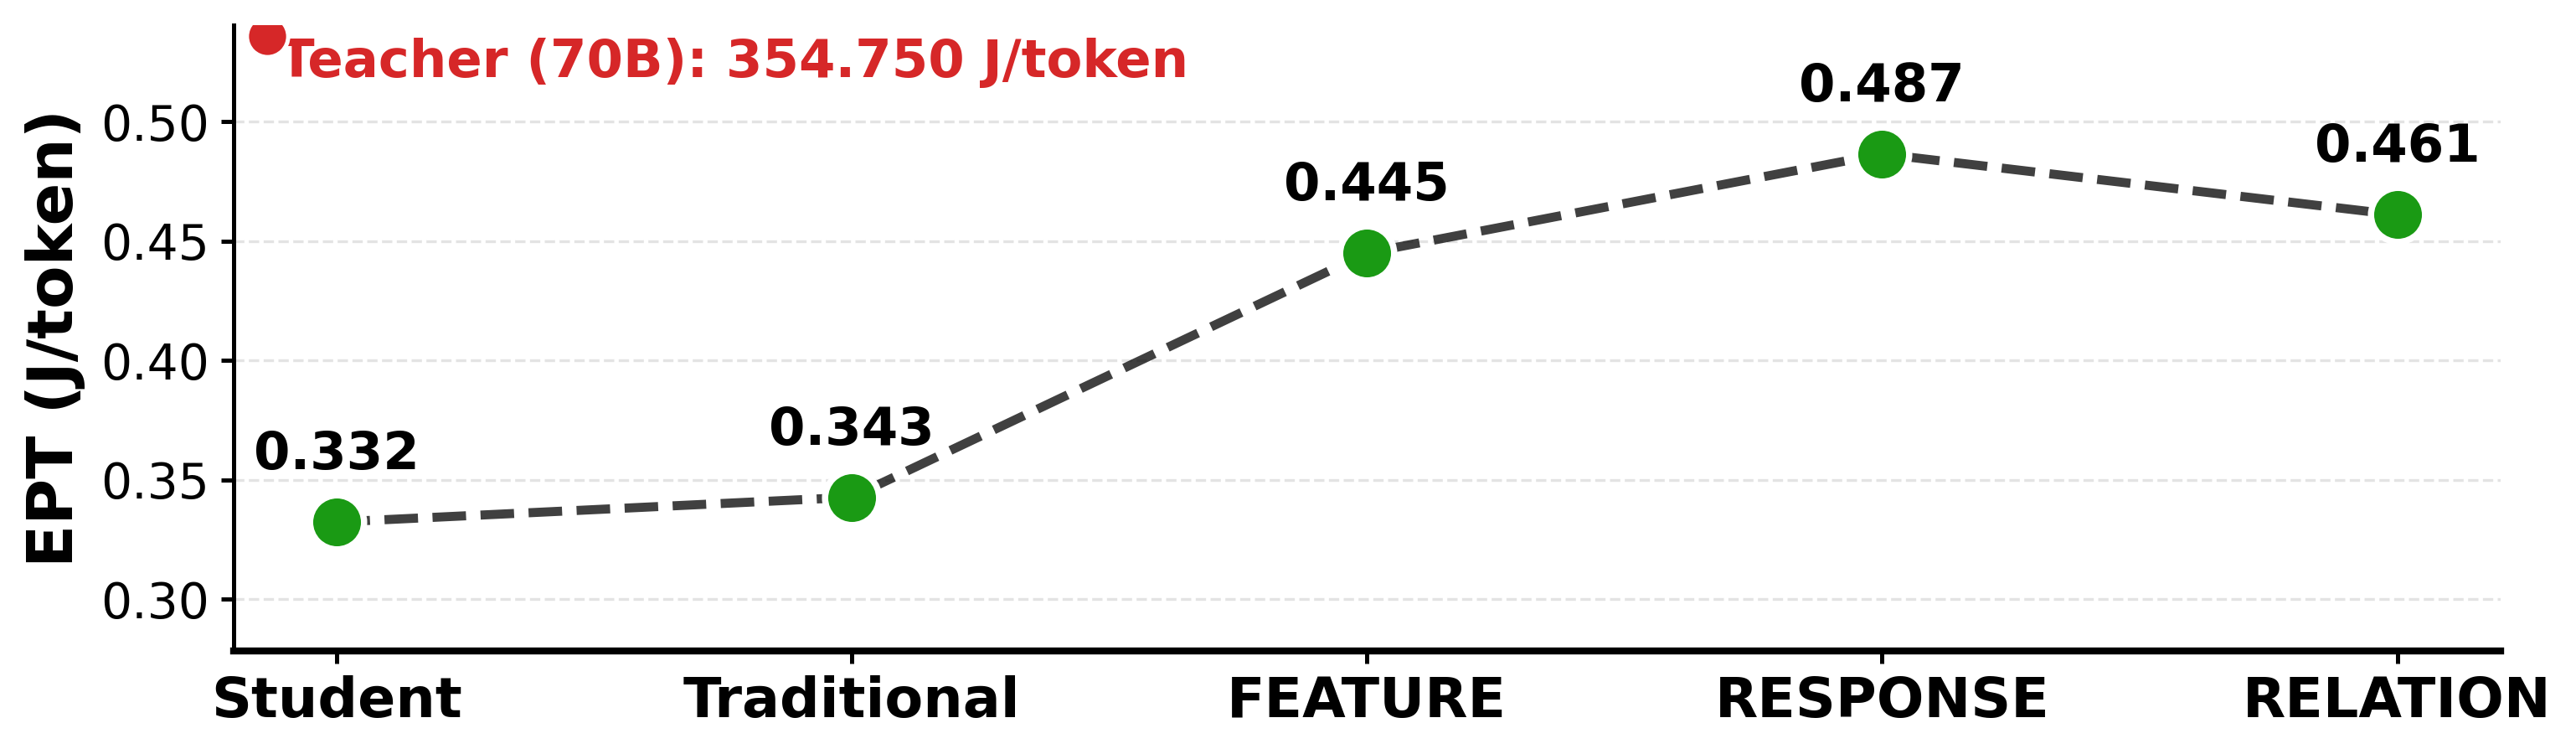

In [6]:
fig, ax = plot_ept_clean_callout(
    df_means,
    cfg={
        # "OUTPDF": "figures/ept_methods_clean_callout.pdf",
        "FIGSIZE": (10.4, 3.1),
        "DOTSIZE": 240,
        "STUDENT_ORDER": ["Student", "Traditional", "FEATURE", "RESPONSE", "RELATION"],
    }
)
plt.show()


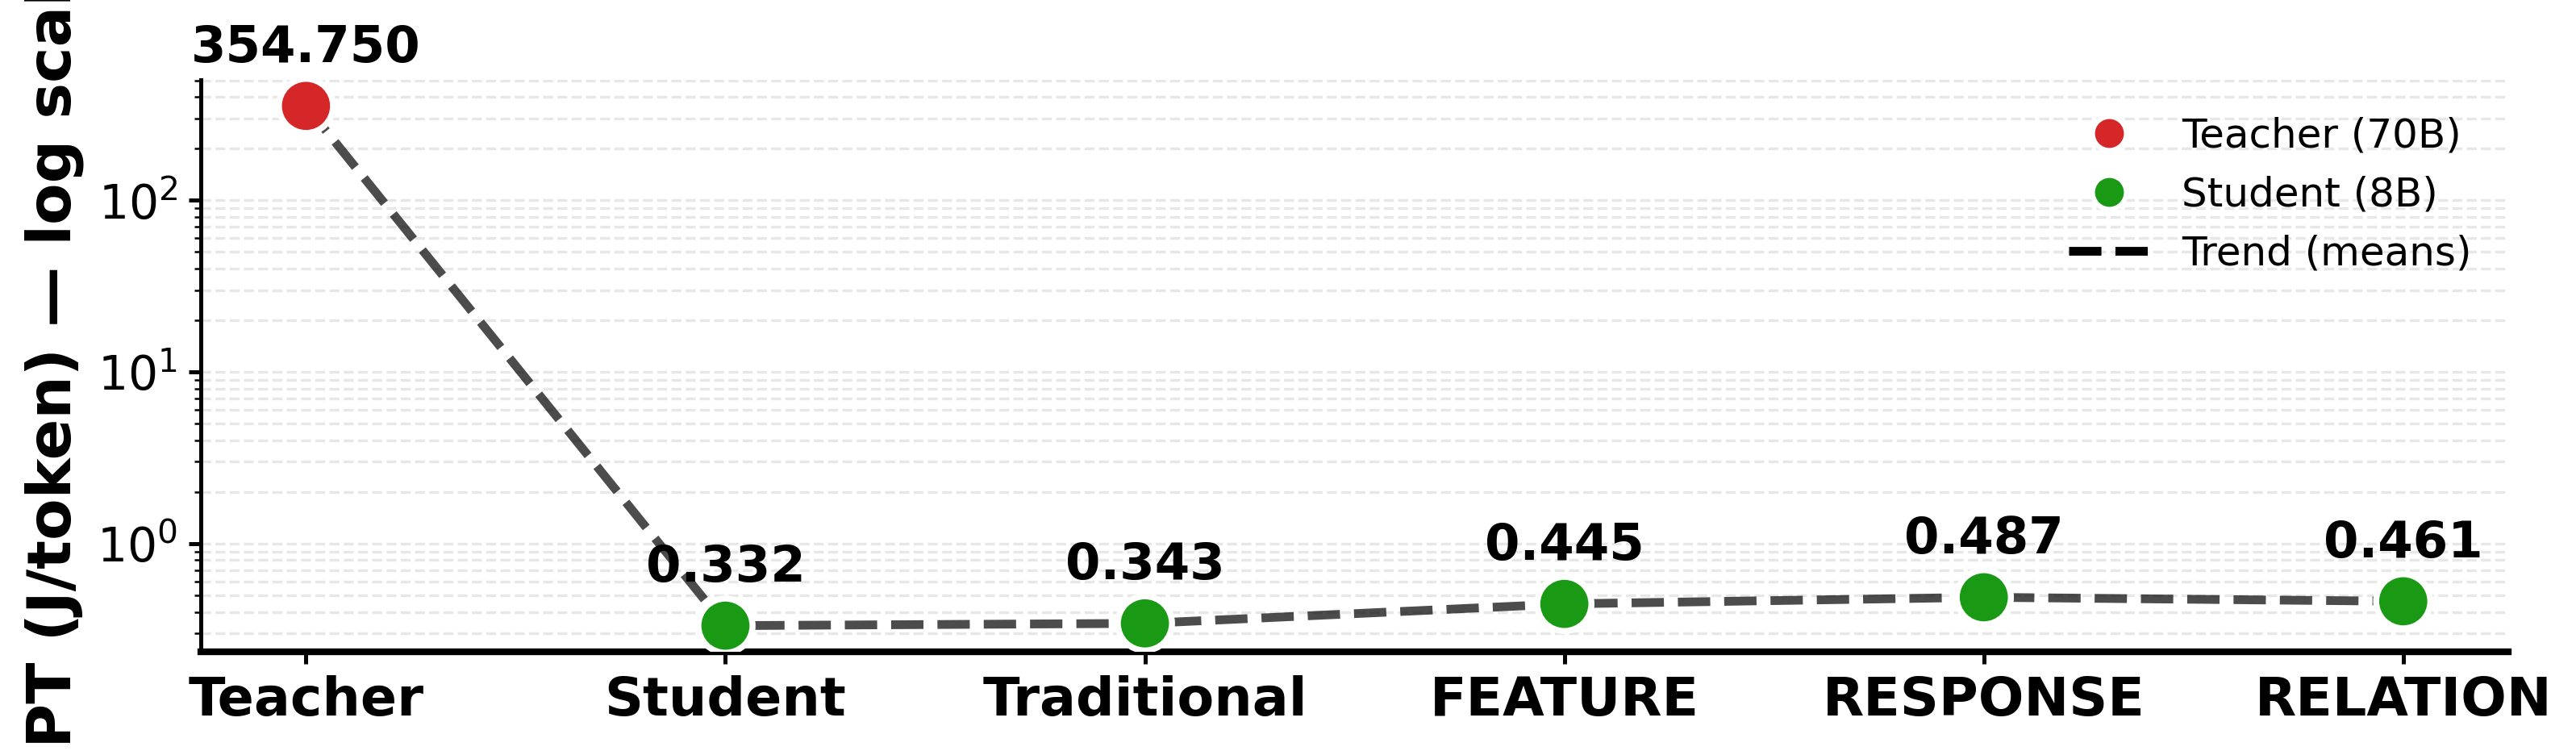

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42  # publisher-friendly

def plot_ept_single_axis_log(df_means: pd.DataFrame, cfg=None):
    if cfg is None:
        cfg = {}

    order = cfg.get("ORDER", ["Teacher", "Student", "Traditional", "FEATURE", "RESPONSE", "RELATION"])

    FIGSIZE = cfg.get("FIGSIZE", (10.6, 3.3))
    DPI     = cfg.get("DPI", 300)
    DOTSIZE = cfg.get("DOTSIZE", 240)

    SAVE   = cfg.get("SAVE", True)
    OUTPDF = cfg.get("OUTPDF", "figures/ept_methods_single_axis_log.pdf")
    OUTSVG = cfg.get("OUTSVG", OUTPDF.replace(".pdf", ".svg"))

    # ---- enforce order ----
    d = df_means.copy()
    d["method"] = d["method"].astype(str)
    d["method"] = pd.Categorical(d["method"], categories=order, ordered=True)
    d = d.sort_values("method").reset_index(drop=True)

    x = np.arange(len(order))
    y = d["ept_mean"].to_numpy(dtype=float)

    # Colors: teacher red, others green (based on params_b or label)
    params = d["params_b"].to_numpy(dtype=float) if "params_b" in d.columns else np.zeros_like(y)
    colors = np.where((d["method"].str.lower() == "teacher") | (params >= 70.0), "#d62728", "#1a9a14")

    fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

    # dashed line across all methods
    ax.plot(x, y, linestyle="--", linewidth=2.6, color="black", alpha=0.70, zorder=2)

    # dots
    ax.scatter(
        x, y,
        s=DOTSIZE,
        c=colors,
        edgecolor="white",
        linewidth=1.8,
        zorder=3,
    )

    # ---- LOG SCALE (key fix) ----
    ax.set_yscale("log")

    # labels above dots (use multiplicative offset for log scale)
    for xi, yi in zip(x, y):
        ax.annotate(
            f"{yi:.3f}",
            xy=(xi, yi),
            xytext=(0, 10),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=15,
            fontweight="bold",
            color="black",
            zorder=4,
        )

    # axis labels
    ax.set_xticks(x)
    ax.set_xticklabels(order, fontsize=18, fontweight="bold")
    ax.set_ylabel("EPT (J/token) — log scale", fontsize=18, fontweight="bold")

    # grid (log-friendly)
    ax.grid(True, which="both", axis="y", linestyle="--", alpha=0.30)
    ax.grid(False, axis="x")
    ax.set_axisbelow(True)

    # spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(2.0)

    ax.tick_params(axis="y", labelsize=14, width=1.2)
    ax.tick_params(axis="x", labelsize=16, width=1.2)

    # optional legend (simple)
    if cfg.get("SHOW_LEGEND", True):
        from matplotlib.lines import Line2D
        handles = [
            Line2D([0],[0], marker="o", color="none", markerfacecolor="#d62728",
                   markeredgecolor="white", markeredgewidth=1.4, markersize=10, label="Teacher (70B)"),
            Line2D([0],[0], marker="o", color="none", markerfacecolor="#1a9a14",
                   markeredgecolor="white", markeredgewidth=1.4, markersize=10, label="Student (8B)"),
            Line2D([0],[0], linestyle="--", color="black", linewidth=2.6, label="Trend (means)"),
        ]
        ax.legend(handles=handles, loc="upper right", frameon=False, fontsize=12)

    fig.tight_layout()

    if SAVE:
        from pathlib import Path
        Path(OUTPDF).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(OUTPDF, bbox_inches="tight")
        fig.savefig(OUTSVG, bbox_inches="tight")

    return fig, ax
fig, ax = plot_ept_single_axis_log(
    df_means,
    cfg={
        "ORDER": ["Teacher", "Student", "Traditional", "FEATURE", "RESPONSE", "RELATION"],
        # "OUTPDF": "figures/ept_methods_single_axis_log.pdf",
        "FIGSIZE": (10.8, 3.2),
        "DOTSIZE": 260,
        "SHOW_LEGEND": True,
    }
)
plt.show()


Saved: figures/ept_broken_axis.pdf
Saved: figures/ept_broken_axis.svg


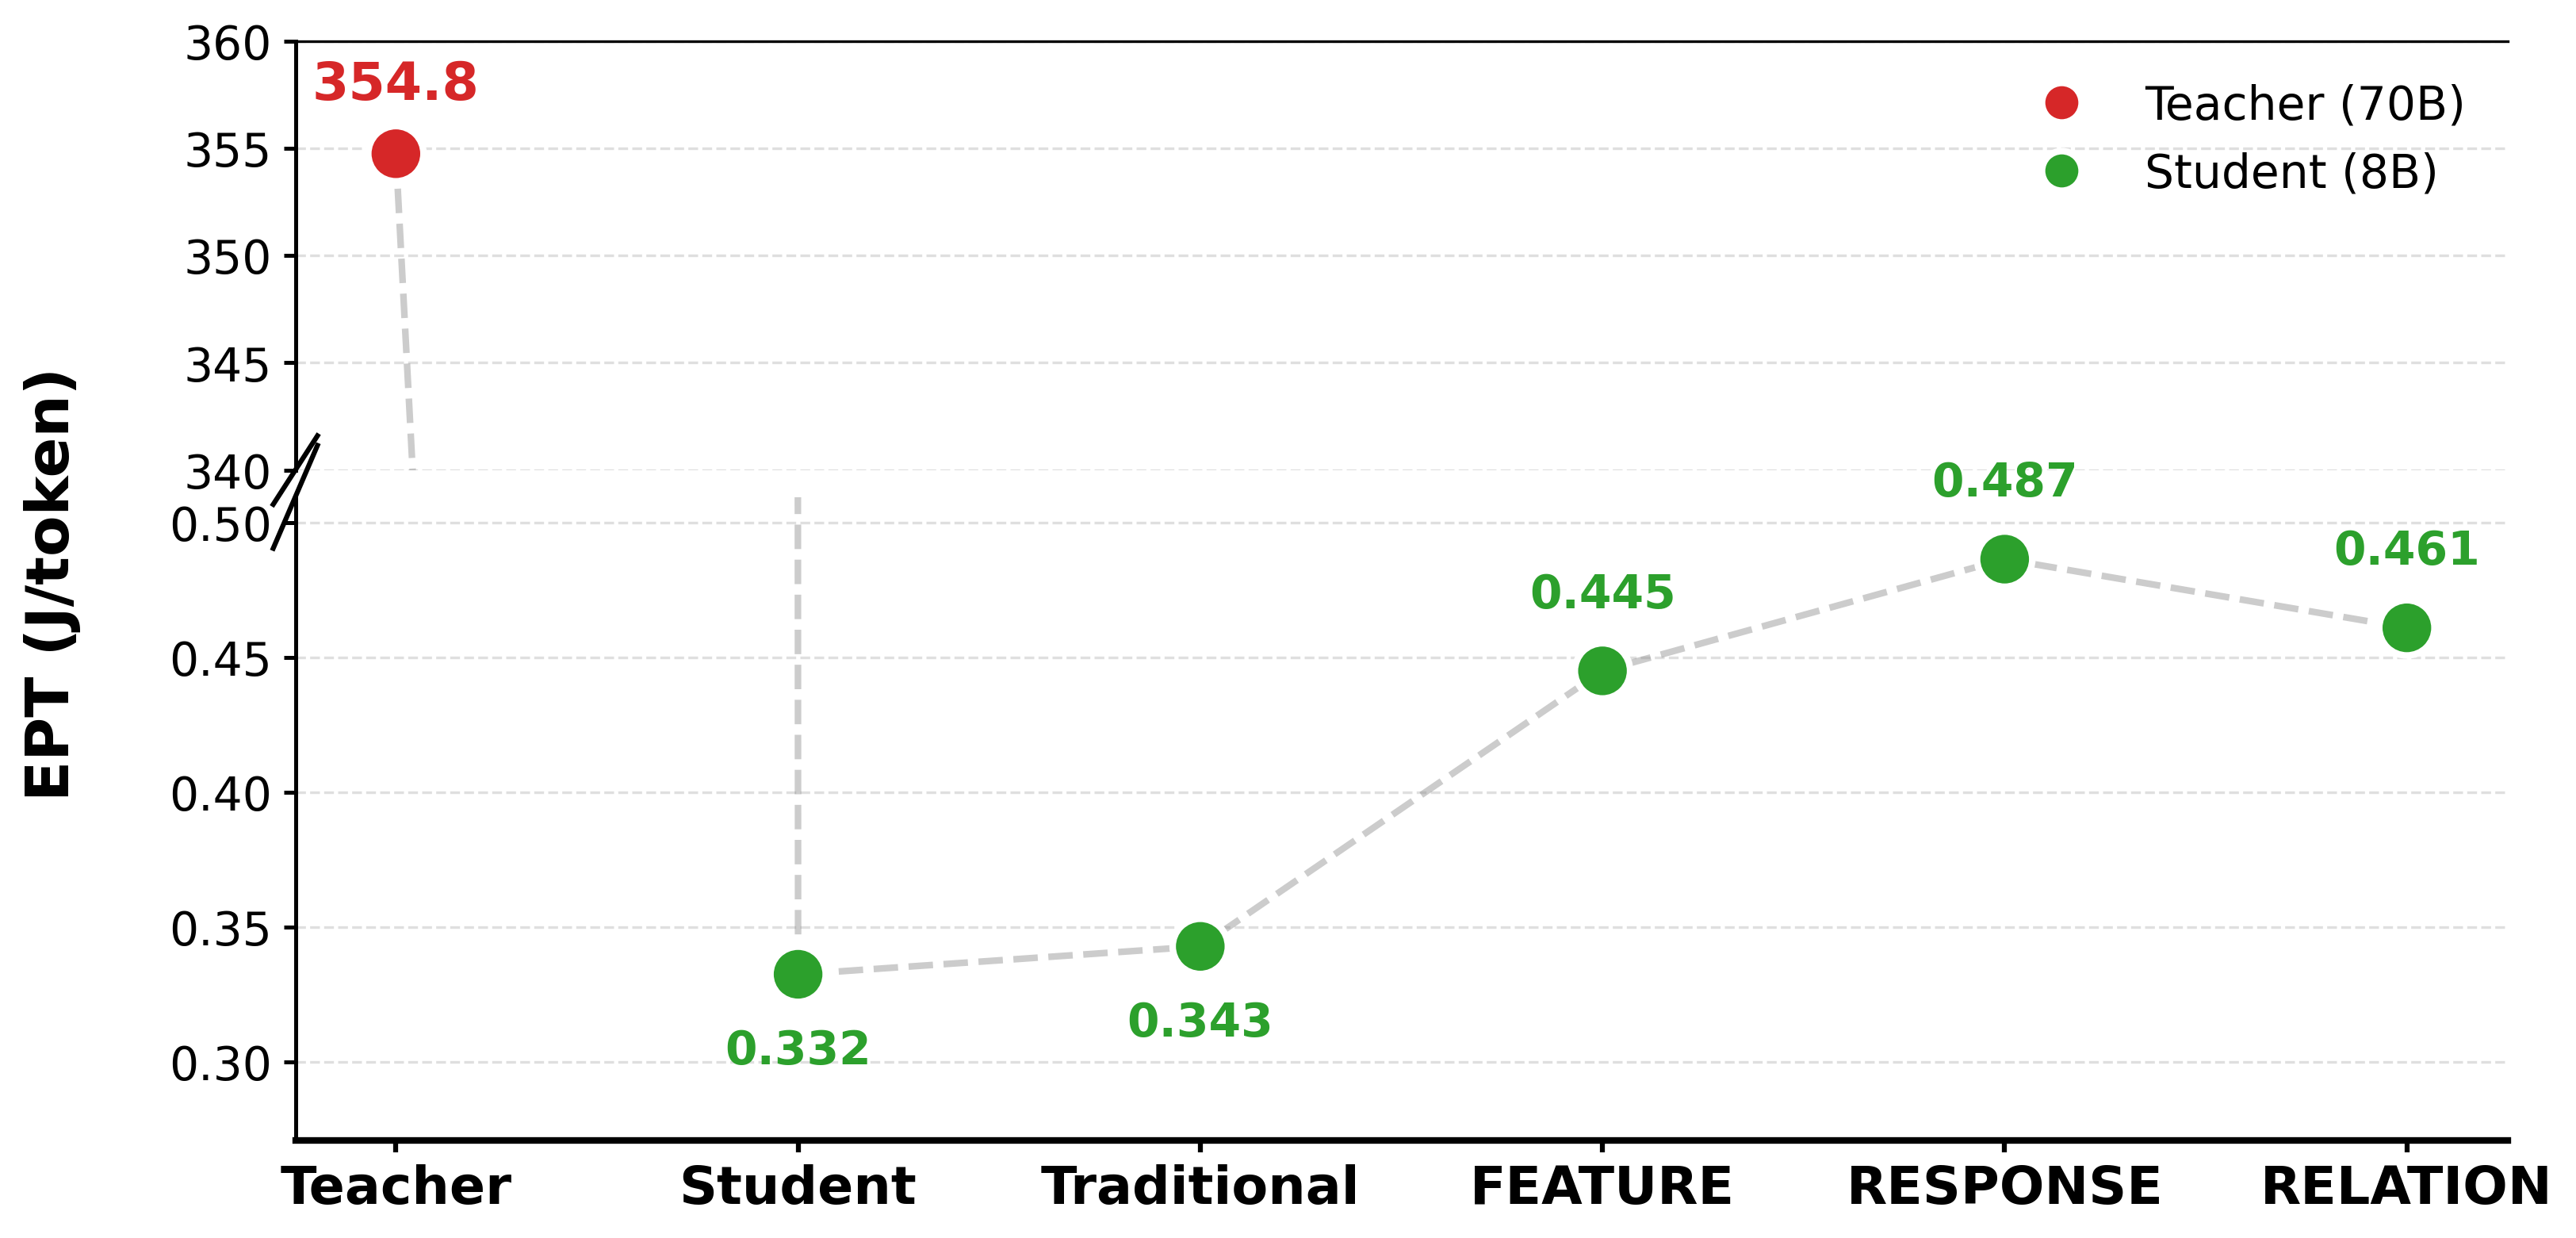

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D

matplotlib.rcParams["pdf.fonttype"] = 42  

def plot_ept_broken_axis(df_means: pd.DataFrame, cfg=None):
    if cfg is None:
        cfg = {}
    
    order = cfg.get("ORDER", ["Teacher", "Student", "Traditional", "FEATURE", "RESPONSE", "RELATION"])
    FIGSIZE = cfg.get("FIGSIZE", (12, 6))
    DPI = cfg.get("DPI", 300)
    DOTSIZE = cfg.get("DOTSIZE", 280)
    
    # Data preparation
    d = df_means.copy()
    d["method"] = pd.Categorical(d["method"], categories=order, ordered=True)
    d = d.sort_values("method").reset_index(drop=True)
    
    x = np.arange(len(order))
    y = d["ept_mean"].to_numpy(dtype=float)
    colors = np.where(d["method"].str.lower() == "teacher", "#d62728", "#2ca02c")
    
    # Create two subplots with shared X-axis
    fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=FIGSIZE, dpi=DPI, 
                                            sharex=True, gridspec_kw={'height_ratios': [1, 1.5]})
    
    fig.subplots_adjust(hspace=0.05)  # Minimize spacing between subplots
    ax_top.scatter(x, y, s=DOTSIZE, c=colors, edgecolor='white', linewidth=2, zorder=3)
    ax_top.plot(x, y, linestyle='--', linewidth=2, color='gray', alpha=0.4, zorder=1)
    
    # Set Y-axis range to focus on Teacher values
    ax_top.set_ylim(340, 360)
    ax_top.spines['bottom'].set_visible(False)
    ax_top.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    
    # No Y-axis label on top subplot (will be added in middle later)
    ax_top.grid(axis='y', linestyle='--', alpha=0.4)
    ax_top.set_axisbelow(True)
    
    # Annotate Teacher values
    for xi, yi, method in zip(x, y, d["method"]):
        if method == "Teacher":
            ax_top.text(xi, yi+2, f'{yi:.1f}', ha='center', va='bottom',
                       fontsize=16, fontweight='bold', color='#d62728')
    
    ax_bottom.scatter(x, y, s=DOTSIZE, c=colors, edgecolor='white', linewidth=2, zorder=3)
    ax_bottom.plot(x, y, linestyle='--', linewidth=2, color='gray', alpha=0.4, zorder=1)
    
    # Calculate Y-axis range for Student models with extended lower margin
    y_student = y[1:]  # Exclude Teacher
    y_min, y_max = y_student.min(), y_student.max()
    margin_bottom = (y_max - y_min) * 0.4  # Larger bottom margin to prevent overlap with x-axis
    margin_top = (y_max - y_min) * 0.15
    ax_bottom.set_ylim(y_min - margin_bottom, y_max + margin_top)
    
    ax_bottom.spines['top'].set_visible(False)
    # NO Y-axis label on bottom subplot (requirement 2)
    ax_bottom.grid(axis='y', linestyle='--', alpha=0.4)
    ax_bottom.set_axisbelow(True)
    
    # Annotate Student values
    for xi, yi, method in zip(x, y, d["method"]):
        if method != "Teacher":
            offset = 0.02 if yi > y_student.mean() else -0.02
            ax_bottom.text(xi, yi+offset, f'{yi:.3f}', ha='center', 
                          va='bottom' if offset > 0 else 'top',
                          fontsize=14, fontweight='bold', color='#2ca02c')
    
    ax_bottom.set_xticks(x)
    ax_bottom.set_xticklabels(order, fontsize=18, fontweight='bold', rotation=0)
    
    d_kwargs = dict(transform=ax_top.transAxes, color='k', clip_on=False, linewidth=1.5)
    ax_top.plot((-0.01, 0.01), (-0.08, 0.08), **d_kwargs)
    # Right side break marker removed
    
    d_kwargs.update(transform=ax_bottom.transAxes)
    ax_bottom.plot((-0.01, 0.01), (0.92, 1.08), **d_kwargs)
    # Right side break marker removed
    
    fig.text(0.04, 0.5, 'EPT (J/token)', fontsize=18, fontweight='bold', 
             rotation='vertical', va='center', ha='center')
    
    handles = [
        Line2D([0], [0], marker='o', color='none', markerfacecolor='#d62728',
               markeredgecolor='white', markeredgewidth=2, markersize=12, label='Teacher (70B)'),
        Line2D([0], [0], marker='o', color='none', markerfacecolor='#2ca02c',
               markeredgecolor='white', markeredgewidth=2, markersize=12, label='Student (8B)'),
    ]
    ax_top.legend(handles=handles, loc='upper right', fontsize=14, frameon=False)
    
    for ax in [ax_top, ax_bottom]:
        ax.tick_params(axis='y', labelsize=14, width=1.2)
        ax.spines['left'].set_linewidth(1.2)
        ax.spines['right'].set_visible(False)
    
    ax_bottom.spines['bottom'].set_linewidth(2.0)
    ax_bottom.tick_params(axis='x', labelsize=16, width=1.5)
    
    if cfg.get("SAVE", True):
        from pathlib import Path
        outpdf = cfg.get("OUTPDF", "figures/ept_broken_axis.pdf")
        Path(outpdf).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(outpdf, bbox_inches='tight', dpi=DPI)
        fig.savefig(outpdf.replace('.pdf', '.svg'), bbox_inches='tight')
        print(f"Saved: {outpdf}")
        print(f"Saved: {outpdf.replace('.pdf', '.svg')}")
    
    return fig, (ax_top, ax_bottom)

fig, (ax_top, ax_bottom) = plot_ept_broken_axis(
    df_means,
    cfg={
        "ORDER": ["Teacher", "Student", "Traditional", "FEATURE", "RESPONSE", "RELATION"],
        # "OUTPDF": "figures/ept_broken_axis_comparison.pdf",
        "FIGSIZE": (12, 6),
        "DOTSIZE": 280,
        "SAVE": True,
    }
)
plt.show()

Saved: figures/updated_ept_broken_axis_comparison.pdf
Saved: figures/updated_ept_broken_axis_comparison.svg


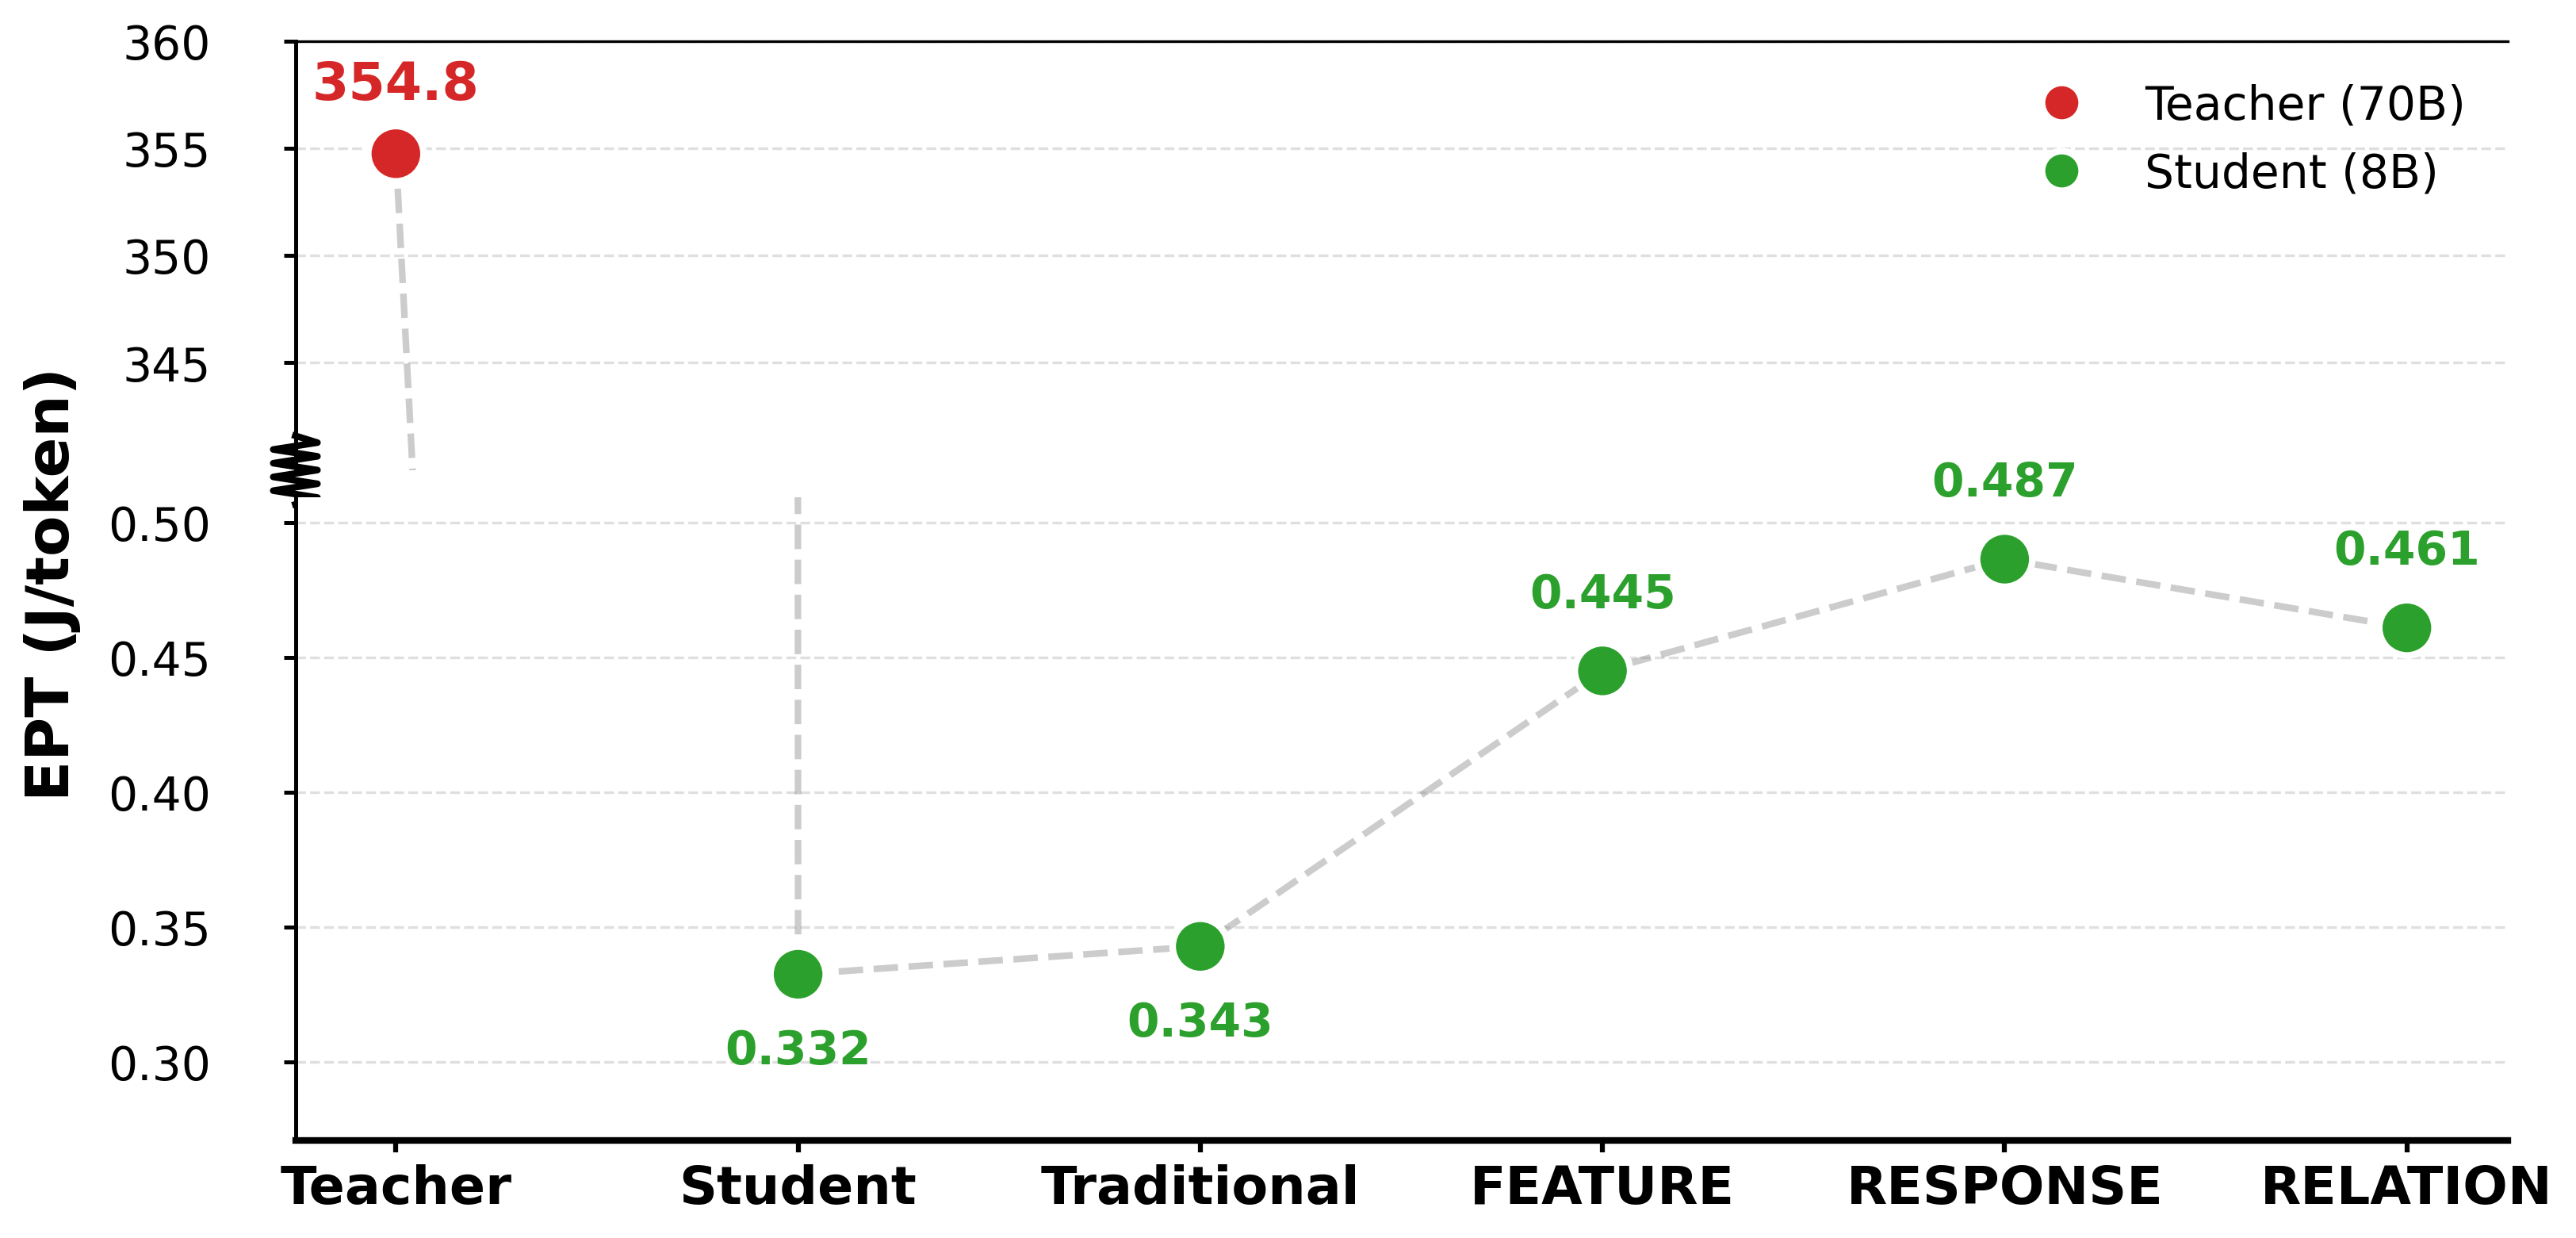

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D

matplotlib.rcParams["pdf.fonttype"] = 42  

def plot_ept_broken_axis(df_means: pd.DataFrame, cfg=None):
    if cfg is None:
        cfg = {}
    
    order = cfg.get("ORDER", ["Teacher", "Student", "Traditional", "FEATURE", "RESPONSE", "RELATION"])
    FIGSIZE = cfg.get("FIGSIZE", (12, 6))
    DPI = cfg.get("DPI", 300)
    DOTSIZE = cfg.get("DOTSIZE", 280)
    
    # Data preparation
    d = df_means.copy()
    d["method"] = pd.Categorical(d["method"], categories=order, ordered=True)
    d = d.sort_values("method").reset_index(drop=True)
    
    x = np.arange(len(order))
    y = d["ept_mean"].to_numpy(dtype=float)
    colors = np.where(d["method"].str.lower() == "teacher", "#d62728", "#2ca02c")
    
    # Create two subplots with shared X-axis
    fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=FIGSIZE, dpi=DPI, 
                                            sharex=True, gridspec_kw={'height_ratios': [1, 1.5]})
    
    fig.subplots_adjust(hspace=0.05)  # Minimize spacing between subplots
    ax_top.scatter(x, y, s=DOTSIZE, c=colors, edgecolor='white', linewidth=2, zorder=3)
    ax_top.plot(x, y, linestyle='--', linewidth=2, color='gray', alpha=0.4, zorder=1)
    
    # Set Y-axis range to focus on Teacher values
    ax_top.set_ylim(340, 360)
    ax_top.set_yticks([345, 350, 355, 360])
    ax_top.spines['bottom'].set_visible(False)
    ax_top.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    
    # No Y-axis label on top subplot (will be added in middle later)
    ax_top.grid(axis='y', linestyle='--', alpha=0.4)
    ax_top.set_axisbelow(True)
    
    # Annotate Teacher values
    for xi, yi, method in zip(x, y, d["method"]):
        if method == "Teacher":
            ax_top.text(xi, yi+2, f'{yi:.1f}', ha='center', va='bottom',
                       fontsize=16, fontweight='bold', color='#d62728')
    
    ax_bottom.scatter(x, y, s=DOTSIZE, c=colors, edgecolor='white', linewidth=2, zorder=3)
    ax_bottom.plot(x, y, linestyle='--', linewidth=2, color='gray', alpha=0.4, zorder=1)
    
    # Calculate Y-axis range for Student models with extended lower margin
    y_student = y[1:]  # Exclude Teacher
    y_min, y_max = y_student.min(), y_student.max()
    margin_bottom = (y_max - y_min) * 0.4  # Larger bottom margin to prevent overlap with x-axis
    margin_top = (y_max - y_min) * 0.15
    ax_bottom.set_ylim(y_min - margin_bottom, y_max + margin_top)
    
    ax_bottom.spines['top'].set_visible(False)
    # NO Y-axis label on bottom subplot (requirement 2)
    ax_bottom.grid(axis='y', linestyle='--', alpha=0.4)
    ax_bottom.set_axisbelow(True)
    
    # Annotate Student values
    for xi, yi, method in zip(x, y, d["method"]):
        if method != "Teacher":
            offset = 0.02 if yi > y_student.mean() else -0.02
            ax_bottom.text(xi, yi+offset, f'{yi:.3f}', ha='center', 
                          va='bottom' if offset > 0 else 'top',
                          fontsize=14, fontweight='bold', color='#2ca02c')
    
    ax_bottom.set_xticks(x)
    ax_bottom.set_xticklabels(order, fontsize=18, fontweight='bold', rotation=0)

    # Resistor-style zigzag break markers (left side only)
    draw_break(ax_top, x=0.00, y=0.0, width=0.02, height=0.16, n_zigs=5, lw=2.0)
    # draw_break(ax_bottom, x=0.0, y=1.0,  width=0.04, height=0.18, n_zigs=5, lw=2.0, color="k")

    
    fig.text(0.04, 0.5, 'EPT (J/token)', fontsize=18, fontweight='bold', 
             rotation='vertical', va='center', ha='center')
    
    handles = [
        Line2D([0], [0], marker='o', color='none', markerfacecolor='#d62728',
               markeredgecolor='white', markeredgewidth=2, markersize=12, label='Teacher (70B)'),
        Line2D([0], [0], marker='o', color='none', markerfacecolor='#2ca02c',
               markeredgecolor='white', markeredgewidth=2, markersize=12, label='Student (8B)'),
    ]
    ax_top.legend(handles=handles, loc='upper right', fontsize=14, frameon=False)
    
    for ax in [ax_top, ax_bottom]:
        ax.tick_params(axis='y', labelsize=14, width=1.2, pad=22)
        ax.spines['left'].set_linewidth(1.2)
        ax.spines['right'].set_visible(False)
    
    ax_bottom.spines['bottom'].set_linewidth(2.0)
    ax_bottom.tick_params(axis='x', labelsize=16, width=1.5)
    
    if cfg.get("SAVE", True):
        from pathlib import Path
        outpdf = cfg.get("OUTPDF", "figures/ept_broken_axis.pdf")
        Path(outpdf).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(outpdf, bbox_inches='tight', dpi=DPI)
        fig.savefig(outpdf.replace('.pdf', '.svg'), bbox_inches='tight')
        print(f"Saved: {outpdf}")
        print(f"Saved: {outpdf.replace('.pdf', '.svg')}")
    
    return fig, (ax_top, ax_bottom)

def draw_break(ax, *, x=0.0, y=0.0, width=0.035, height=0.16, n_zigs=6,
                        lw=2.0, color="k"):
    """
    Draw a resistor-like zigzag centered at (x, y) in AXES coordinates.
    - (x, y) are in ax.transAxes space
    - width/height are also in axes fraction units
    """
    # x,y are center; build a zigzag around them
    y0 = y - height / 2.0
    y1 = y + height / 2.0
    x0 = x - width / 2.0
    x1 = x + width / 2.0

    ys = np.linspace(y0, y1, n_zigs * 2 + 1)
    xs = np.empty_like(ys)
    xs[0] = (x0 + x1) / 2.0  # start centered

    toggle = True
    for i in range(1, len(ys) - 1):
        xs[i] = x1 if toggle else x0
        toggle = not toggle

    xs[-1] = (x0 + x1) / 2.0  # end centered

    ax.plot(xs, ys, transform=ax.transAxes, color=color, lw=lw, clip_on=False)



fig, (ax_top, ax_bottom) = plot_ept_broken_axis(
    df_means,
    cfg={
        "ORDER": ["Teacher", "Student", "Traditional", "FEATURE", "RESPONSE", "RELATION"],
        "OUTPDF": "figures/updated_ept_broken_axis_comparison.pdf",
        "FIGSIZE": (12, 6),
        "DOTSIZE": 280,
        "SAVE": True,
    }
)
plt.show()